In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
robo_flags=pd.read_csv('/nobackup/khauskne/kdd/robovetter_flags_all_DR25.csv')

In [7]:
robo_flags

,Unnamed: 0,target_id,tce_plnt_num,TCE,Robovetter_Score,Disposition,Not_Transit-Like_Flag,Stellar_Eclipse_Flag,Centroid_Offset_Flag,Ephemeris_Match_Flag,Minor_Descriptive_Flags,Global Flux Flag,Local Flux Flag,Centroid Flag,Odd Even Flag,Secondary Flag,Stellar Flag,DV Flag
0,0,757099,1,000757099-01,0.000,FP,1,0,0,0,LPP_DV---LPP_ALT---MOD_NONUNIQ_DV,0,1,0,0,0,0,0
1,1,757450,1,000757450-01,0.999,PC,0,0,0,0,NO_COMMENT,0,0,0,0,0,0,0
2,2,892376,1,000892376-01,0.000,FP,1,0,0,0,INDIV_TRANS_CHASES_MARSHALL---LPP_DV---ALL_TRA...,0,1,0,0,0,0,0
3,3,892376,2,000892376-02,0.000,FP,1,0,0,0,LPP_DV---MOD_NONUNIQ_DV---CENT_KIC_POS,0,1,0,0,0,0,0
4,4,892376,3,000892376-03,0.000,FP,1,0,0,0,INDIV_TRANS_RUBBLE---TRANS_GAPPED---LPP_DV---L...,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,32529,12885212,1,012885212-01,0.001,FP,0,0,1,0,CENT_RESOLVED_OFFSET,0,0,1,0,0,0,0
32530,32530,12885212,2,012885212-02,0.638,PC,0,0,0,0,NO_COMMENT,0,0,0,0,0,0,0
32531,32531,12885505,1,012885505-01,0.000,FP,1,0,0,0,INDIV_TRANS_MARSHALL---LPP_DV---INCONSISTENT_T...,0,1,0,0,0,0,0
32532,32532,12935144,1,012935144-01,0.000,FP,0,0,1,0,CENT_RESOLVED_OFFSET---HALO_GHOST,0,0,1,0,0,0,1


In [8]:
def apply_statistics(branches, files, num_PCs):
    """ Compute statistics for scores across `num_PCs` results for each branch for a given data set and trial run.

    :param branches: list, groupings of features
    :param files: list, list of DataFrames that contain the scores for the different data sets (train, val, and test) [n_examples x (n_branches + other info cols)]
    :param num_PCs: int, number of representative PCs used

    :return: pandas DataFrame, mean and minimum scores across num_PCs for each branch for a given data set and trial run [n_examples x (n_branches + other info cols)]
    """

    new_csv=files[0].copy()
    new_csv.pop('Unnamed: 0')
    for branch in branches:
        all_scores=np.zeros(tuple((num_PCs, np.shape(files[0])[0])))
        for example in range(len(files)):
            all_scores[example]=files[example][branch]
        col_index=new_csv.columns.get_loc(branch)
        new_csv[branch]=np.mean(all_scores, axis=0)
        new_csv.insert(col_index+1, branch+' Std', np.std(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Max', np.max(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Min', np.min(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Med', np.median(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Mean+Std', np.mean(all_scores, axis=0)+np.std(all_scores, axis=0))
        new_csv.insert(col_index+1, branch+' Mean-Std', np.mean(all_scores, axis=0)-np.std(all_scores, axis=0))
    return new_csv



def evaluate_mean(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]]<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'], 'minor_flags':csv['Minor_Descriptive_Flags'],'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_min(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Min']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_max(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Max']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict

def evaluate_med(csv, branches):
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    robo=np.array(csv[csv.columns[-7:]])
    reduced_csv=csv
    branch_explanation=np.zeros([len(branches), len(csv)])
    for i in range(len(branches)):
        branch_explanation[i]=(reduced_csv[branches[i]+ ' Med']<-0.5)
    branch_explanation=np.moveaxis(branch_explanation, 0, -1)
    csv=pd.merge(csv, robo_flags, on=['target_id', 'tce_plnt_num'])
    mean_dict={'target_id': csv['target_id'], 'tce_plnt_num': csv['tce_plnt_num'], 'original_label':csv['original_label'],
              'full_score': csv['full score'],  'minor_flags':csv['Minor_Descriptive_Flags'], 'branch_explanations': branch_explanation, 'robo_flags': robo}
    return mean_dict


In [9]:
def summary_statistics(stat_func, num_PCs, trials):
    train=[]
    val=[]
    test=[]
    for trial in range(1, trials+1):
        run='/nobackup/khauskne/kdd/explainability_runs/exp_'+str(num_PCs)+'_PCs_trial_'+str(trial)+'/'
        #print(run)
        all_train_groups=[]
        for index in range(num_PCs):
            train_group=pd.read_csv(run+'train_top_'+str(index)+'.csv')
            all_train_groups.append(train_group)
    

        all_val_groups=[]
        for index in range(num_PCs):
            val_group=pd.read_csv(run+'val_top_'+str(index)+'.csv')
            all_val_groups.append(val_group)

        all_test_groups=[]
        for index in range(num_PCs):
            test_group=pd.read_csv(run+'test_top_'+str(index)+'.csv')
            all_test_groups.append(test_group)

        branches=['Global Flux', 'Local Flux', 'Centroid', 'Odd Even', 'Secondary', 'Stellar', 'DV']
        train_statistics=apply_statistics(branches, all_train_groups, num_PCs)
        val_statistics=apply_statistics(branches, all_val_groups, num_PCs)
        test_statistics=apply_statistics(branches, all_test_groups, num_PCs)
        
        train.append(stat_func(train_statistics, branches))
        val.append(stat_func(val_statistics, branches))
        test.append(stat_func(test_statistics, branches))

    return train, val, test

In [6]:
stats=summary_statistics(evaluate_min, 1, 10)

In [16]:
def metric_1(stat_func, num_pcs, trials):
    #at least one robovetter flag is identified
    stats=summary_statistics(stat_func, num_pcs,trials)
    metrics_list=[]
    loc_flux_mistakes=[]
    for i in range(trials):
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        test_comments=stats[2][i]['minor_flags'].str.split(pat='---')
    
        num=0
        denom=0
        #loc_flux_mistake_num=0
        #loc_flux_mistake_denom=0
        #all_mistake_flags=[]
        for ind in range(len(test_robo)):
            denom=denom+1
            robo_flags_on=np.where(test_robo[ind]==1)[0]
            exp_flags_on=np.where(test_exp[ind]==1)[0]
            if (np.shape(robo_flags_on)[0]>0):
                if (np.shape(np.intersect1d(robo_flags_on, exp_flags_on))[0]>0):
                    num=num+1
                else:
                    #print(robo_flags)
                    #print(exp_flags)
                    #all_mistake_flags.append(test_comments[ind])
                    
                    if (1 in robo_flags_on):
                        if (0 in exp_flags_on):
                            num=num+1
                        #else:
                        #print(exp_flags_on)
            elif (np.shape(robo_flags_on)[0]==0):
                if (np.shape(exp_flags_on)[0]==0):
                    num=num+1
        metrics_list.append(num/denom)
        #loc_flux_mistakes.append([loc_flux_mistake_num, loc_flux_mistake_denom, loc_flux_mistake_num/loc_flux_mistake_denom])
    return np.mean(metrics_list), np.std(metrics_list)#, loc_flux_mistakes, np.unique(np.concatenate(all_mistake_flags, axis=0), return_counts=True)

In [18]:
def metric_2(stat_func, num_pcs, trials):
    #Percent of total robovetter flags found
    stats=summary_statistics(stat_func, num_pcs,trials)
    
    metrics_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']

        num=0
        denom=0
        for ind in range(len(test_robo)):
            robo_flags_on=np.where(test_robo[ind]==1)[0]
            exp_flags_on=np.where(test_exp[ind]==1)[0]
            num_robo_flags=np.shape(robo_flags_on)[0]
            denom=denom+num_robo_flags
            if (np.shape(robo_flags_on)[0]>0):
                num_intersect=np.shape(np.intersect1d(robo_flags_on, exp_flags_on))[0]
                if (num_intersect>0):
                    num=num+num_intersect
                if (1 in robo_flags_on):
                    if (1 not in exp_flags_on):
                        if (0 in exp_flags_on):
                            num=num+1
        metrics_list.append(num/denom)

    return np.mean(metrics_list), np.std(metrics_list)

In [34]:
def acc_for_flag(stat_func, num_pcs, trials):
    #at least one robovetter flag is identified
    stats=summary_statistics(stat_func, num_pcs,trials)
    metrics_list=np.zeros([10, 7])
    loc_flux_mistakes=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        test_comments=stats[2][i]['minor_flags'].str.split(pat='---')
    
        for flag_num in [1,2,3,4,6]:
            #flag_ind=0
            #indiv_flag=[]
            num=0
            denom=0
            for ind in range(len(test_robo)):
                robo_flags_on=np.where(test_robo[ind]==1)[0]
                exp_flags_on=np.where(test_exp[ind]==1)[0]
                if (flag_num in robo_flags_on):
                    denom=denom+1
                    if (flag_num in exp_flags_on):
                        num=num+1
            metrics_list[i][flag_num]=num/denom
            #indiv_flag.append(num/denom)
            #indiv_flag=np.moveaxis(indiv_flag, 0, -1)[0]
    metrics_list=np.moveaxis(metrics_list, 0, -1)
    print(metrics_list)
    mean_std=[np.mean(metrics_list, axis=1), np.std(metrics_list, axis=1)]
    print('____')
    print(mean_std)
    return mean_std#np.mean(metrics_list), np.std(metrics_list)

In [ ]:
#It's one thing to randomly choose examples and show that our explainability works, should we randomly choose some Robovetter examples and look at the flagging accuracy?

In [20]:
min_vals=[]
min_vals_std=[]
for i in range(1,15):
    vals=metric_1(evaluate_min, i, 10)
    min_vals.append(vals[0])
    min_vals_std.append(vals[1])
    print(vals[0])

0.8013385569702904
0.8008488410055501
0.8204701273261508
0.8135161606268364
0.8326803787136795
0.8237675481554032
0.8397975840679074
0.8397649363369245
0.8455762324518448
0.8449232778321907
0.8433888344760041
0.8457068233757752
0.8346392425726412
0.8359451518119491


Text(0.5, 1.0, 'Metric 1 Analysis with Minimum Criteria')

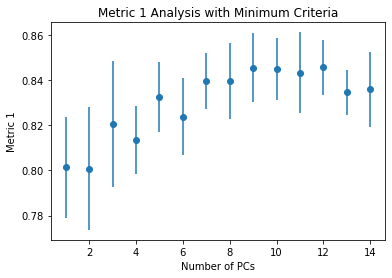

In [21]:
plt.errorbar(np.arange(1,15), min_vals, min_vals_std, fmt='o')
plt.xlabel('Number of PCs')
plt.ylabel('Metric 1')
plt.title('Metric 1 Analysis with Minimum Criteria')

In [19]:
min_vals_2=[]
min_vals_std_2=[]
for i in range(1,15):
    vals=metric_2(evaluate_min, i, 10)
    min_vals_2.append(vals[0])
    min_vals_std_2.append(vals[1])
    print(vals[0])

0.7648648648648648
0.7767303889255108
0.7998352010547133
0.7992748846407383
0.8352999340804217
0.8293012524719842
0.8563612392880685
0.8520105471324984
0.86430454845089
0.872874093605801
0.8624917600527355
0.8718852999340804
0.8457811470006593
0.860744891232696


Text(0.5, 1.0, 'Metric 2 Analysis with Minimum Criteria')

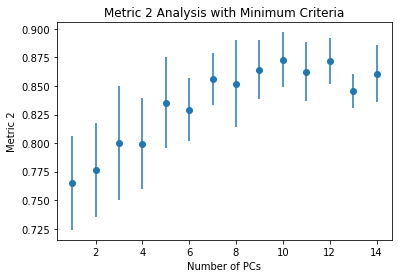

In [22]:
plt.errorbar(np.arange(1,15), min_vals_2, min_vals_std_2, fmt='o')
plt.xlabel('Number of PCs')
plt.ylabel('Metric 2')
plt.title('Metric 2 Analysis with Minimum Criteria')

In [37]:
acc_for_flag(evaluate_min, 10, 10)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.87669948 0.86075949 0.9517112  0.88560713 0.79324895 0.87201125
  0.75058603 0.76652602 0.87810595 0.84950774]
 [0.79087452 0.75285171 0.83269962 0.7756654  0.66920152 0.77946768
  0.72243346 0.82509506 0.77186312 0.76806084]
 [0.03333333 0.03333333 0.05       0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]
 [0.83268482 0.81712062 0.80933852 0.81712062 0.81712062 0.82879377
  0.80933852 0.83657588 0.81712062 0.81712062]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.72897196 0.64797508 0.80685358 0.76635514 0.66043614 0.57320872
  0.63551402 0.85981308 0.63551402 0.61370717]]
____
[array([0.        , 0.84847632, 0.76882129, 0.035     , 0.82023346,
       0.        , 0.69283489]), array([0.        , 0.05810754, 0.04498277, 0.005     , 0.00883877,
       0.        , 0.08820326])]


[array([0.        , 0.84847632, 0.76882129, 0.035     , 0.82023346,
        0.        , 0.69283489]),
 array([0.        , 0.05810754, 0.04498277, 0.005     , 0.00883877,
        0.        , 0.08820326])]

In [12]:
def metric_4(stat_func, num_pcs, trials):
    stats=summary_statistics(stat_func, num_pcs,trials)
    
    metrics_list=[]
    for i in range(trials):
        #print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']

        exp_new_total=0
        robo_total=0
        for ind in range(len(test_robo)):
            robo_flags_on=np.where(test_robo[ind]==1)[0]
            exp_flags_on=np.where(test_exp[ind]==1)[0]
            num_robo_flags=np.shape(robo_flags_on)[0]
            num_exp_flags=np.shape(exp_flags_on)[0]
            robo_total=robo_total+num_robo_flags
            exp_new_total=exp_new_total+num_exp_flags
            metrics_list.append(exp_new_total)
    print(robo_total)
    return np.mean(metrics_list), np.std(metrics_list)

In [13]:
num_vals=[]
num_vals_std=[]
for i in range(1,15):
    vals=metric_4(evaluate_min, i, 10)
    num_vals.append(vals[0])
    num_vals_std.append(vals[1])
    print(vals[0])

3034
3125.5973555337905
3034
3249.282598759386
3034
3450.2316030035913
3034
3502.1667646098595
3034
3815.775612144956
3034
3813.730395037545
3034
4044.1172053542277
3034
3925.943258243552
3034
4140.263891609533
3034
4356.088834476004
3034
4104.3939928175
3034
4306.079562520405
3034
3919.773294156056
3034
4261.080378713679


## Below Plots are from before fixing the global/local flux issue

<BarContainer object of 19 artists>

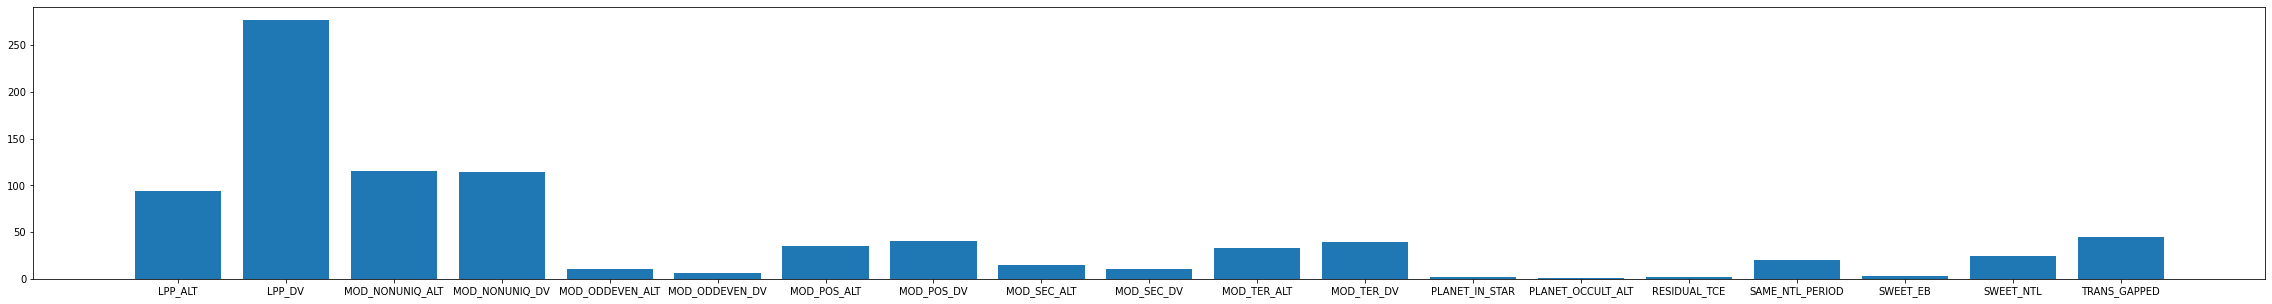

In [60]:
plt.figure(figsize=(40,5))
plt.bar(mets[2][0][43:], mets[2][1][43:])

In [66]:
min_vals=[]
min_vals_std=[]
for i in range(1,15):
    vals=metric_1(evaluate_min, i, 10)
    min_vals.append(vals[0])
    min_vals_std.append(vals[1])
    print(vals[0])


[0.6938731091522473]
[0.6938731091522473, 0.7010556099684405]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004, 0.723473718576559]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004, 0.723473718576559, 0.7597489752239998]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004, 0.723473718576559, 0.7597489752239998, 0.7517684187615628]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004, 0.723473718576559, 0.7597489752239998, 0.7517684187615628, 0.7854318569303879]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004, 0.723473718576559, 0.7597489752239998, 0.7517684187615628, 0.7854318569303879, 0.7840896724344325]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004, 0.723473718576559, 0.7597489752239998, 0.7517684187615628, 0.7854318569303879, 0.7840896724344325, 0.7971487648275112]
[0.6938731091522473, 0.7010556099684405, 0.7363514346864004, 0.723473718576559, 0.759748975223999

Text(0.5, 1.0, 'Metric 1 Analysis with Minimum Criteria')

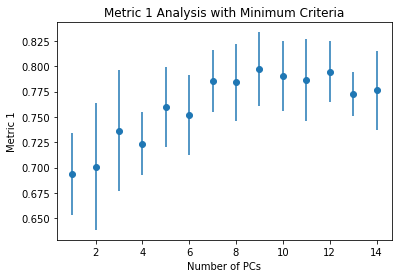

In [69]:
plt.errorbar(np.arange(1,15), min_vals, min_vals_std, fmt='o')
plt.xlabel('Number of PCs')
plt.ylabel('Metric 1')
plt.title('Metric 1 Analysis with Minimum Criteria')

In [70]:
mean_vals=[]
mean_vals_std=[]
for i in range(1,15):
    vals=metric_1(evaluate_mean, i, 10)
    mean_vals.append(vals[0])
    mean_vals_std.append(vals[1])
    print(vals[0])

0.6938731091522473
0.664308774984583
0.670149091304821
0.6706206696412377
0.6768600137845975
0.6757717560851744
0.6809953930424057
0.6745746726158086
0.6718177531106034
0.6766060869880653
0.6719991293938405
0.6838974135742011
0.6627126636920956
0.6587949359741719


In [72]:
min_vals_2=[]
min_vals_std_2=[]
for i in range(1,15):
    vals=metric_2(evaluate_min, i, 10)
    min_vals_2.append(vals[0])
    min_vals_std_2.append(vals[1])
    print(vals[0])

0.6419102028858127
0.6659708488976782
0.7038379843257893
0.6977953563319416
0.7502380429209697
0.7451109646231597
0.7905222295466198
0.7838570277594668
0.8049512927561708
0.8036695231817182
0.7923167069508534
0.8080275397348569
0.7697209404526477
0.7872628726287263


Text(0.5, 1.0, 'Metric 1 Analysis with Minimum Criteria')

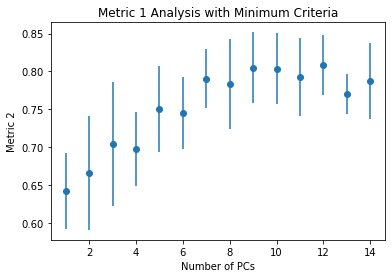

In [73]:
plt.errorbar(np.arange(1,15), min_vals_2, min_vals_std_2, fmt='o')
plt.xlabel('Number of PCs')
plt.ylabel('Metric 2')
plt.title('Metric 1 Analysis with Minimum Criteria')

In [74]:
mean_vals_2=[]
mean_vals_std_2=[]
for i in range(1,15):
    vals=metric_2(evaluate_mean, i, 10)
    mean_vals_2.append(vals[0])
    mean_vals_std_2.append(vals[1])
    print(vals[0])

0.6419102028858127
0.6083644620229987
0.6047388852266901
0.6116238189408921
0.6141507361019557
0.6173368490441661
0.6226104152933422
0.6099025855123416
0.6124661246612466
0.6178129348861057
0.6116604409287336
0.6271515417856882
0.5942283747161796
0.5959862301325717


In [165]:
def acc_for_flag(stat_func, num_pcs, trials):
    #at least one robovetter flag is identified
    stats=summary_statistics(stat_func, num_pcs,trials)
    metrics_list=np.zeros([10, 5])
    loc_flux_mistakes=[]
    for i in range(trials):
        print(i)
        train_exp=stats[0][i]['branch_explanations']
        val_exp=stats[1][i]['branch_explanations']
        test_exp=stats[2][i]['branch_explanations']
        train_robo=stats[0][i]['robo_flags']
        val_robo=stats[1][i]['robo_flags']
        test_robo=stats[2][i]['robo_flags']
        test_comments=stats[2][i]['minor_flags'].str.split(pat='---')
    
        for flag_num in [1,2,3,4,6]:
            flag_ind=0
            indiv_flag=[]
            num=0
            denom=0
            for ind in range(len(test_robo)):
                robo_flags_on=np.where(test_robo[ind]==1)[0]
                exp_flags_on=np.where(test_exp[ind]==1)[0]
                if (flag_num in robo_flags_on):
                    denom=denom+1
                    if (flag_num in exp_flags_on):
                        num=num+1
            
            indiv_flag.append(num/denom)
            indiv_flag=np.moveaxis(indiv_flag, 0, -1)[0]
        metrics_list[i]=indiv_flag
    return metrics_list#np.mean(metrics_list), np.std(metrics_list)

In [166]:
acc_for_flag(evaluate_min, 1, 10)

0
1
2
3
4
5
6
7
8
9


array([[0.53582555, 0.53582555, 0.53582555, 0.53582555, 0.53582555],
       [0.40186916, 0.40186916, 0.40186916, 0.40186916, 0.40186916],
       [0.70716511, 0.70716511, 0.70716511, 0.70716511, 0.70716511],
       [0.30218069, 0.30218069, 0.30218069, 0.30218069, 0.30218069],
       [0.64797508, 0.64797508, 0.64797508, 0.64797508, 0.64797508],
       [0.26479751, 0.26479751, 0.26479751, 0.26479751, 0.26479751],
       [0.3364486 , 0.3364486 , 0.3364486 , 0.3364486 , 0.3364486 ],
       [0.56697819, 0.56697819, 0.56697819, 0.56697819, 0.56697819],
       [0.36137072, 0.36137072, 0.36137072, 0.36137072, 0.36137072],
       [0.25545171, 0.25545171, 0.25545171, 0.25545171, 0.25545171]])

In [89]:
local_flux_acc=[]
local_flux_acc_std=[]
for i in range(1,15):    
    acc=acc_for_flag(evaluate_min, i, 10, 1)
    local_flux_acc.append(acc[0])
    local_flux_acc_std.append(acc[1])
    print(acc[0])

0.6848465906131165
0.6985466479137364
0.7532947856435901
0.7344376725530031
0.7924675730582903
0.7808511746627077
0.8348179403031725
0.837370422461843
0.8585716518205969
0.8453404177736104
0.8363806844819502
0.8513830285982185
0.8142418086159295
0.8203365109131635
